# Learning disentangled representations in Flatland

This notebook uses our method to learn either entangled or disentangled representations in the Flatland environment (see Caselles-Dupré, Hugo, et al. "Flatland: a lightweight first-person 2-d environment for reinforcement learning." arXiv preprint arXiv:1809.00510 (2018).)

In [1]:
import os
import gym
import math
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

os.chdir('src/flatland/flat_game/')
from env import Env


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Linux (64bit) [/home/william/.local/lib/python3.6/site-packages/pymunk/libchipmunk.so]


# Flatworld environment

We start by defining the flatworld environment, which is based on the code available at https://github.com/Caselles/NeurIPS19-SBDRL. This environment returns pixel observations of a ball on a cyclical 2D grid. The available (discrete) actions step the ball by a fixed amount in all four directions.

In [416]:
RADIUS = 15
PERIOD = 10

class FlatWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))       

    class observation_space():
        def __init__(self):
            self.shape = [84,84]
    
    def __init__(self, env_parameters, period=10, radius=15):

        self.action_space = self.action_space(4)
        self.observation_space = self.observation_space()  
        self.period = period
        
        self.step_size = 0.1*(63-2*env_parameters['agent']['radius'])/period
        start_positions_list = [27 + 10*self.step_size*i for i in range(period)]
        self.start_positions = []
        for i in start_positions_list:
            for j in start_positions_list:
                self.start_positions.append((i,j))
                        
        env_parameters['agent']['radius'] = radius
        self.env = Env(**env_parameters)
        
    def reset(self, start_position=None):
        if start_position==None:
            obs = self.env.reset(position=random.sample(self.start_positions, 1)[0])
        else:
             obs = self.env.reset(position=start_position)
        return torch.FloatTensor(obs)/255
    
    def step(self, action):
        action_dict = self.create_action_dict(action)
        obs, reward, done, info = self.env.step(action_dict)
        return torch.FloatTensor(obs)/255
    
    def create_action_dict(self, action):
        action_dict = {}
        if action == 0:
            action_dict['longitudinal_velocity'] = 0
            action_dict['lateral_velocity'] = self.step_size
            action_dict['angular_velocity'] = 0
        if action == 1:
            action_dict['longitudinal_velocity'] = 0
            action_dict['lateral_velocity'] = -self.step_size
            action_dict['angular_velocity'] = 0
        if action == 2:
            action_dict['longitudinal_velocity'] = self.step_size
            action_dict['lateral_velocity'] = 0
            action_dict['angular_velocity'] = 0
        if action == 3:
            action_dict['longitudinal_velocity'] = -self.step_size
            action_dict['lateral_velocity'] = 0
            action_dict['angular_velocity'] = 0
        return action_dict
        

In [311]:
agent_parameters = {
    'radius': 15,
    'speed': 10,
    'rotation_speed' : math.pi/8,
    'living_penalty': 0,
    'position': (30,30),
    'angle': 0,
    'sensors': [
      
        {
           'nameSensor' : 'proximity_test',
           'typeSensor': 'proximity',
           'fovResolution': 64,
           'fovRange': 300,
           'fovAngle': math.pi ,
           'bodyAnchor': 'body',
           'd_r': 0,
           'd_theta': 0,
           'd_relativeOrientation': 0,
           'display': False,
        }
        
       
    ],
    'actions': ['forward', 'turn_left', 'turn_right', 'left', 'right', 'backward'],
    'measurements': ['health', 'poisons', 'fruits'],
    'texture': {
        'type': 'color',
        'c': (255, 255, 255)
    },
    'normalize_measurements': False,
    'normalize_states': False,
    'normalize_rewards': False
}

env_parameters = {
    'map':False,
    'n_rooms': 2,
    'display': False,
    'horizon': 10001,
    'shape': (84, 84),
    'mode': 'time',
    'poisons': {
        'number': 0,
        'positions': 'random',
        'size': 10,
        'reward': -10,
        'respawn': True,
        'texture': {
            'type': 'color',
            'c': (255, 255, 255),
        }
    },
    'fruits': {
        'number': 0,
        'positions': 'random',
        'size': 10,
        'reward': 10,
        'respawn': True,
        'texture': {
            'type': 'color',
            'c': (255, 150, 0),
        }
    },
    'obstacles': [
       
    ],
    'walls_texture': {
        'type': 'color',
        'c': (1, 1, 1)
    },
    'agent': agent_parameters
}

**Now show a few consecutive states from this environment**

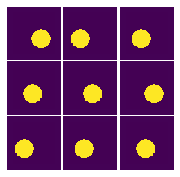

In [4]:
import matplotlib.gridspec as gridspec

env = FlatWorld(env_parameters, period=PERIOD, radius=RADIUS)
plt.figure(figsize = (3,3))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.02, hspace=0.02)
plt.grid(None)
state = env.reset()
for i in range(9):
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.set_aspect('equal')
    ax.imshow(state)
    display.display(plt.gcf())
    time.sleep(0.2)
    display.clear_output(wait=True)
    action = random.sample([0,1,2,3],k=1)[0]
    action = 2
    #print(env.env.agent.body.position)
    state = env.step(action)
    
plt.savefig("env.png", bbox_inches='tight')

### Latent space

**Encoder/Decoder**

Now we want to learn to represent this environment in some latent space (which we, for now, simply assume to be 4-dimensional).  We will require both an encoder and decoder, which will use convolutional neural networks.

In [5]:
class Encoder(nn.Module):

    def __init__(self, n_out=4, n_hid = 64):

        super().__init__()

        self.conv = nn.Conv2d(1, 5, 10, stride=3)
        self.fc1 = nn.Linear(180, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)

    def forward(self, x):
        x = F.relu(self.conv(x.unsqueeze(0).unsqueeze(1)))
        x = F.max_pool2d(x, 4, 4)
        x = x.view(-1, 180)
        x = F.relu(self.fc1(x))
        return F.normalize(self.fc2(x)).squeeze()

class Decoder(nn.Module):
    
    def __init__(self, n_in=4, n_hid = 64):

        super().__init__()
        
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, 180)
        self.conv = nn.ConvTranspose2d(5, 1, 34, stride=10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(1,5,6,6)
        x = self.conv(x)
        return torch.sigmoid(x).squeeze()

In [6]:
encoder = Encoder(n_out=4)
decoder = Decoder(n_in=4)
print(encoder)
print(decoder)

Encoder(
  (conv): Conv2d(1, 5, kernel_size=(10, 10), stride=(3, 3))
  (fc1): Linear(in_features=180, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)
Decoder(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=180, bias=True)
  (conv): ConvTranspose2d(5, 1, kernel_size=(34, 34), stride=(10, 10))
)


**Make sure dimensions match**

In [7]:
obs = torch.FloatTensor(state)
print(obs.shape)
latent = encoder(obs)
print(latent.shape)
reconstructed = decoder(latent)
print(reconstructed.shape)

torch.Size([84, 84])
torch.Size([4])
torch.Size([84, 84])


**Representation**

The crux of the matter is learning to 'represent' actions in the observation space with actions in latent space.  Here, we will do this by assuming every action is a generalized rotation in latent space, which we denote with a series of 2-dimensional rotations.

A 2-d rotation is given by:

\begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}

and we denote a rotation in dimensions $i$ and $j$ of a higher dimensional space as $R_{i,j}(\theta)$.  For $i=1$, $j=4$, in a 4-dimensional space:

\begin{equation}
R_{1,4}(\theta) = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & \sin(\theta) \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}
\end{equation}

An arbitrary rotation, denoted $g$ as I am subtly moving towards this being a group action, can then be written as:

\begin{equation}
    g(\theta_{1,2},\theta_{1,3},\dots,\theta_{n-1,n}) = \prod_{i=1}^{n-1} \prod_{j=1+1}^{n} R_{i,j}(\theta_{i,j})
\end{equation}

which has $n(n-1)/2$ free parameters (i.e. $\theta_{i,j}$'s).

In [8]:
class Representation():

    def __init__(self, dim=4):
        self.dim = dim
        self.params = dim*(dim-1)//2
        self.thetas = torch.autograd.Variable(np.pi*(2*torch.rand(self.params)-1)/dim, requires_grad=True)

        self.__matrix = None
    
    def set_thetas(self, thetas):
        self.thetas = thetas
        self.thetas.requires_grad = True
        self.clear_matrix()
    
    def clear_matrix(self):
        self.__matrix = None
        
    def get_matrix(self):
        if self.__matrix is None:
            k = 0
            mats = []
            for i in range(self.dim-1):
                for j in range(self.dim-1-i):
                    theta_ij = self.thetas[k]
                    k+=1
                    c, s = torch.cos(theta_ij), torch.sin(theta_ij)

                    rotation_i = torch.eye(self.dim, self.dim)
                    rotation_i[i, i] = c
                    rotation_i[i, i+j+1] = s
                    rotation_i[j+i+1, i] = -s
                    rotation_i[j+i+1, j+i+1] = c

                    mats.append(rotation_i)

            def chain_mult(l):
                if len(l)>=3:
                    return l[0]@l[1]@chain_mult(l[2:])
                elif len(l)==2:
                    return l[0]@l[1]
                else:
                    return l[0]

            self.__matrix = chain_mult(mats)
                                    
        return self.__matrix

**LatentWorld**

Now, for symmetry's sake, we'll also have a `LatentWorld` which acts as the environment in the latent space.

In [9]:
class LatentWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,
                 dim=4,
                 n_actions=4,
                 action_reps=None):

        self.dim = dim

        self.action_space = self.action_space(n_actions)
        self.observation_space = self.observation_space(dim)
        
        if action_reps is None:
            self.action_reps = [Representation(dim=self.dim) for _ in range(n_actions)]
        else:
            if len(action_reps)!=n_actions:
                raise Exception("Must pass an action representation for every action.")
            if not all([rep.dim==self.dim]):
                raise Exception("Action representations do not act on the dimension of the latent space.")
            self.action_reps = action_reps
        
    def reset(self, state_init):
        self.state = state_init
        return self.get_observation()
    
    def clear_representations(self):
        for rep in self.action_reps:
            rep.clear_matrix()
            
    def get_representation_params(self):
        params = []
        for rep in self.action_reps:
            params.append(rep.thetas)
        return params
    
    def save_representations(self, path):
        if os.path.splitext(path)[-1] != '.pth':
            path += '.pth'
        rep_thetas = [rep.thetas for rep in self.action_reps]
        return torch.save(rep_thetas, path)
    
    def load_reprentations(self, path):
        rep_thetas = torch.load(path)
        for rep in self.action_reps:
            rep.set_thetas(rep_thetas.pop(0))
            
    def get_observation(self):
        return self.state
    
    def step(self,action):
        self.state = torch.mv(self.action_reps[action].get_matrix(), self.state)
        obs = self.get_observation()
        return obs

## 3. Training

So the basic training loop is pretty straightfoward.  We simply play out episodes from random starting configurations, encoded by the `Encoder`, for `ep_steps` time-steps.  Each random action is executed in both the `FlatWorld` and the `LatentWorld`, and then the latent state is transformed to the observation space by the `Decoder` where the loss function measures its deviation from the true state.

Note: sometimes training without the disentanglement regularization fails to find toroidal structure, especially when the radius of the ball is very small. 

In [ ]:
dim = 4

obs_env = FlatWorld(env_parameters, period=PERIOD, radius=RADIUS)
lat_env = LatentWorld(dim = dim,
                      n_actions = obs_env.action_space.n)
decoder = Decoder(n_in = dim, n_hid = 64)
encoder = Encoder(n_out = dim, n_hid = 64)

optimizer_dec = optim.Adam(decoder.parameters(),
                           lr=1e-2,
                           weight_decay=0)

optimizer_enc = optim.Adam(encoder.parameters(),
                           lr=1e-2,
                           weight_decay=0)

optimizer_rep = optim.Adam(lat_env.get_representation_params(),
                           lr=1e-2,
                           weight_decay=0)

losses = []

In [ ]:
n_sgd_steps = 3000
ep_steps = 5
batch_eps = 16

i = 0

t_start = time.time()

temp = 0

while i < n_sgd_steps:
    
    loss = torch.zeros(1)
    
    for _ in range(batch_eps):
        t_ep = -1
        while t_ep < ep_steps:
            if t_ep == -1:
                obs_x = obs_env.reset()
                obs_z = lat_env.reset(encoder(obs_x))
            else:
                action = obs_env.action_space.sample().item()
                obs_x = obs_env.step(action)
                obs_z = lat_env.step(action)
            
            t_ep += 1         
            
            obs_x_recon = decoder(obs_z)

            loss += F.binary_cross_entropy(obs_x_recon, obs_x)
        
    loss /= (ep_steps*batch_eps)
                        
    losses.append(loss.item())
    
    optimizer_dec.zero_grad()
    optimizer_enc.zero_grad()
    optimizer_rep.zero_grad()
    loss.backward()
    optimizer_enc.step()
    optimizer_dec.step()
    optimizer_rep.step()
        
    # Remember to clear the cached action representations after we update the parameters!
    lat_env.clear_representations()

    i+=1
    
    if i%10==0:
        print("iter {} : loss={:.3f} : last 10 iters in {:.3f}s".format(i, loss.item(), time.time() - t_start),
              end="\r" if i%100 else "\n")
        t_start = time.time()

## 4. Testing

Testing is easy too, we just play out an episode and see how well the reconstructed image agrees with the ground truth!

In [ ]:
def plot_state(obs, ax):
    ax.imshow(obs)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 10

fig, (ax1,ax2) = plt.subplots(1, 2)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = obs_env.reset()
        obs_z = lat_env.reset(encoder(obs_x))
    else:
        action = obs_env.action_space.sample().item()
        obs_x = obs_env.step(action)
        obs_z = lat_env.step(action)
        
    obs_x_recon = decoder(obs_z)
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)

We will now have a look at the latent space, we will make a 2D projection of the 4D latent space for every possible frame (There are 121 possible frames in this environment). Note that since we use random projections, in some cases the toric structure we find is more obvious than in others.

**Positions in latent space**

In [ ]:
from sklearn.random_projection import GaussianRandomProjection

latent_points = []

for start_position in obs_env.start_positions:
    obs = obs_env.reset(start_position=start_position)
    latent = encoder(obs)
    latent_points.append(latent.detach().tolist())

latent_map = np.array(latent_points)

In [ ]:
period = obs_env.period

color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',"#2fa36b"]
marks=["1","2","3","4","+",">","<","^","v","x","d"]
pca = GaussianRandomProjection(n_components=2)

latent_2d = pca.fit_transform(latent_map)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)#, projection='3d')
s=[120]*5+[50]*6
for i in range (period**2):
    ax.scatter(x=latent_2d.transpose()[0][i],
                y=latent_2d.transpose()[1][i],
                c=color[i//period], 
                s=s[i%period],
                marker=marks[i%period])
plt.title('Representations - Our method',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.show()
plt.savefig("latent_flatland.png", bbox_inches='tight')

**2) Plot Action Representations**

In [ ]:
width=0.5

rep_thetas = [rep.thetas.detach().numpy() for rep in lat_env.action_reps]

for rep in lat_env.action_reps:
    print(rep.get_matrix())
    print(torch.matrix_power(rep.get_matrix(), 5))

plt_lim = max( 0.12, max([max(t) for t in rep_thetas])/(2*np.pi) )
titles = ["up", "down", "right", "left"]

with plt.style.context('seaborn-paper', after_reset=True):

    fig, axs = plt.subplots(1, len(rep_thetas), figsize=(15, 3), gridspec_kw={"wspace":0.4})
    
    for i, thetas in enumerate(rep_thetas):
        x = np.arange(len(thetas))
        axs[i].bar(x - width/2, thetas/(2*np.pi), width, label='Rep {}'.format(i))
        axs[i].hlines((0.2,-0.2), -2., 7., linestyles="dashed")
        axs[i].hlines(0., -2., 7.)
        axs[i].set_xticks(x-0.25)
        axs[i].set_xticklabels(["12","13","14","23","24","34"], fontsize = 15)
        axs[i].set_xlabel("$ij$", fontsize = 15)
        
        axs[i].set_ylim(-plt_lim,plt_lim)
        axs[i].set_xlim(-.75, 5.75)
        axs[i].set_title(titles[i], fontsize = 15)
        
        axs[i].tick_params(labelsize=15)

    axs[0].set_ylabel(r"$\theta / 2\pi$", fontsize = 15)
    plt.savefig("action_rep_entangled.png", bbox_inches='tight')
    

## 5. Disentanglement

***Some jargon***

It's nice that it works, but the real point here is to try and learn a *disentangled* representation of the actions.

Before considering how best to do this, we want to define a metric of 'disentanglement'.  We consider the evolution of an observable (latent) vector, $x \in X$ ($z \in Z$), under the element $g \in G$ of the group of symmetries generating transformations of the object.  Then we are looking for a representation, $\rho:G \rightarrow GL(V)$, such that the transformation is linear in the latent space, i.e.
\begin{equation}
    z^{\prime} = \rho(g) \cdot z.
\end{equation}
Note, in our case, the representations are the rotation matrices we learn.

For this representation to be disentangled, it means that if there exists a subgroup decomposition of $G$
\begin{equation}
    G = G_1 \times G_2 \times \dots \times G_n,
\end{equation}
then we equivalently decompose the representation, $(\rho, G)$, into subrepresentations:
\begin{equation}
    V = V_1 \oplus V_2 \oplus \dots \oplus V_n
\end{equation}
such that the restricted subrepresentations $(\rho_{\vert G_i}, V_i)_i$ are non-trivial, and the restricted subrepresentations $(\rho_{\vert G_i}, V_j)_{j \neq i}$ are trivial.

In our context, a GridWorld with 5 points in each dimension is represented by $G = C_5 \times C_5$ (where $C_5$ is the cyclic group).  This is a subgroup of $\mathrm{SO}(2) \times \mathrm{SO}(2)$, therefore we hope to find the disentangled representation of the actions (up, down, left, right) that corresponds to this.

***Some practicalities***

Our intuition is that the disentangled representation acts as the identity on as many dimensions as possible.  We could attempt to enforce this with some regularization during training.  Normal weight decay won't cut it, as that tries to reduce all weights, where as what we really want to do is have all *but one* of our thetas (which corresponds to the rotation/coupling of two dimensions) to be zero.

**1. Entanglement regularisation**

So for $m$ parameters, ${\theta_1, \dots, \theta_m}$, we want to regularise with
\begin{equation}
    \sum_{i \neq j} \vert\theta_i\vert^2, \mathrm{where\ } \theta_j {=} \mathrm{max_k}({\vert\theta_k\vert}).
\end{equation}
We will also use this term as our metric of 'entanglement'.

In [10]:
def calc_entanglement(params):
    params = params.abs().pow(2)
    return params.sum() - params.max()

params = torch.FloatTensor([1,1,0.5,0,0])
calc_entanglement(params)

tensor(1.2500)

### Training with regularization

In [465]:
dim = 4

obs_env = FlatWorld(env_parameters, period=PERIOD, radius=RADIUS)
lat_env = LatentWorld(dim = dim,
                      n_actions = obs_env.action_space.n)
decoder = Decoder(n_in = dim, n_hid = 64)
encoder = Encoder(n_out = dim, n_hid = 64)

optimizer_dec = optim.Adam(decoder.parameters(),
                           lr=1e-2,
                           weight_decay=0)

optimizer_enc = optim.Adam(encoder.parameters(),
                           lr=1e-2,
                           weight_decay=0)

optimizer_rep = optim.Adam(lat_env.get_representation_params(),
                           lr=1e-2,
                           weight_decay=0)

losses = []
entanglement = []

In [466]:
n_sgd_steps = 3000
ep_steps = 5
batch_eps = 16
entanglement_target = 0

i = 0

t_start = time.time()

temp = 0

while i < n_sgd_steps:
    
    loss = torch.zeros(1)
    
    for _ in range(batch_eps):
        t_ep = -1
        while t_ep < ep_steps:
            if t_ep == -1:
                obs_x = obs_env.reset()
                obs_z = lat_env.reset(encoder(obs_x))
            else:
                action = obs_env.action_space.sample().item()
                obs_x = obs_env.step(action)
                obs_z = lat_env.step(action)
            
            t_ep += 1         
            
            obs_x_recon = decoder(obs_z)

            loss += F.binary_cross_entropy(obs_x_recon, obs_x)
        
    loss /= (ep_steps * batch_eps)
    raw_loss = loss.item()
    
    reg_loss = sum([calc_entanglement(r.thetas) for r in lat_env.action_reps])/4
    
    loss += (reg_loss-entanglement_target).abs() * 1e-2
                        
    losses.append(raw_loss)
    entanglement.append(reg_loss.item())
    
    optimizer_dec.zero_grad()
    optimizer_enc.zero_grad()
    optimizer_rep.zero_grad()
    loss.backward()
    optimizer_enc.step()
    optimizer_dec.step()
    optimizer_rep.step()
        
    # Remember to clear the cached action representations after we update the parameters!
    lat_env.clear_representations()

    i+=1
    
    if i%10==0:
        print("iter {} : loss={:.3f} : entanglement={:.2e} : last 10 iters in {:.3f}s".format(
            i, raw_loss, reg_loss.item(), time.time() - t_start
            ), end="\r" if i%100 else "\n")
        t_start = time.time()

iter 100 : loss=0.196 : entanglement=1.28e-01 : last 10 iters in 2.261s
iter 200 : loss=0.110 : entanglement=1.64e-01 : last 10 iters in 2.717s
iter 300 : loss=0.079 : entanglement=1.37e-01 : last 10 iters in 2.428s
iter 400 : loss=0.068 : entanglement=1.21e-01 : last 10 iters in 2.503s
iter 500 : loss=0.058 : entanglement=9.97e-02 : last 10 iters in 2.390s
iter 600 : loss=0.052 : entanglement=7.73e-02 : last 10 iters in 2.173s
iter 700 : loss=0.047 : entanglement=6.18e-02 : last 10 iters in 2.457s


/home/william/Bureau/Python/gantime/rep-learning/paris/src/flatland/flat_game/sensors/proximity_sensor.py:42: RuntimeWarning: invalid value encountered in not_equal
  mask = resized_img != 0


iter 800 : loss=0.045 : entanglement=4.67e-02 : last 10 iters in 2.678s
iter 900 : loss=0.045 : entanglement=3.69e-02 : last 10 iters in 3.733s
iter 1000 : loss=0.041 : entanglement=2.65e-02 : last 10 iters in 2.215s
iter 1100 : loss=0.042 : entanglement=2.10e-02 : last 10 iters in 2.264s
iter 1200 : loss=0.040 : entanglement=1.57e-02 : last 10 iters in 2.423s
iter 1300 : loss=0.040 : entanglement=1.22e-02 : last 10 iters in 2.254s
iter 1400 : loss=0.039 : entanglement=8.43e-03 : last 10 iters in 3.703s
iter 1500 : loss=0.040 : entanglement=7.17e-03 : last 10 iters in 3.049s
iter 1600 : loss=0.039 : entanglement=5.31e-03 : last 10 iters in 2.675s
iter 1700 : loss=0.037 : entanglement=4.04e-03 : last 10 iters in 2.599s
iter 1800 : loss=0.039 : entanglement=3.47e-03 : last 10 iters in 2.330s
iter 1900 : loss=0.038 : entanglement=2.71e-03 : last 10 iters in 2.874s
iter 2000 : loss=0.038 : entanglement=2.13e-03 : last 10 iters in 2.481s
iter 2100 : loss=0.042 : entanglement=1.38e-03 : last

### Testing: action representations

tensor([[ 8.0866e-01, -1.1173e-03,  5.8828e-01, -1.2253e-03],
        [-3.0675e-03,  9.9997e-01,  6.1077e-03, -3.9406e-03],
        [-5.8827e-01, -6.7483e-03,  8.0864e-01, -1.1613e-03],
        [ 2.9561e-04,  3.9313e-03,  1.6840e-03,  9.9999e-01]],
       grad_fn=<MmBackward>)
tensor([[-0.9997, -0.0219, -0.0032, -0.0046],
        [-0.0218,  0.9996, -0.0034, -0.0197],
        [ 0.0033, -0.0033, -1.0000,  0.0028],
        [-0.0051,  0.0196,  0.0027,  0.9998]], grad_fn=<MmBackward>)
tensor([[ 8.0502e-01, -5.6523e-03, -5.9318e-01, -6.5949e-03],
        [-3.1073e-03,  9.9990e-01, -1.3751e-02,  5.6601e-04],
        [ 5.9320e-01,  1.2915e-02,  8.0495e-01, -2.2810e-03],
        [ 6.6641e-03, -5.7379e-04, -2.0682e-03,  9.9998e-01]],
       grad_fn=<MmBackward>)
tensor([[-9.9839e-01, -4.4817e-02,  3.4711e-02,  6.5951e-04],
        [-4.4964e-02,  9.9898e-01, -3.5485e-03,  3.5622e-03],
        [-3.4526e-02, -5.0236e-03, -9.9914e-01, -2.2290e-02],
        [ 4.9066e-05, -3.6419e-03, -2.2287e-02,  9.

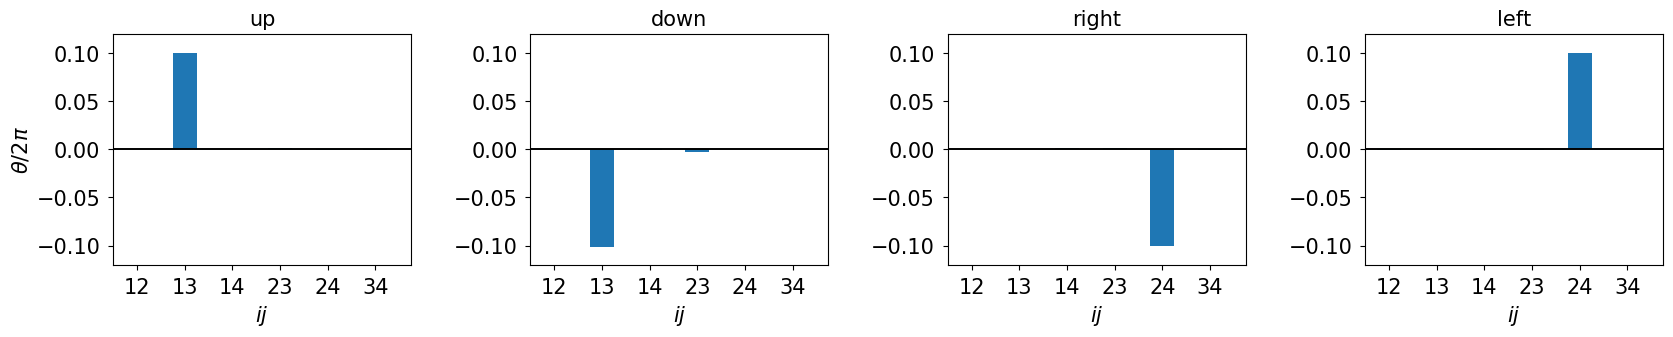

In [472]:
width=0.5

rep_thetas = [rep.thetas.detach().numpy() for rep in lat_env.action_reps]

for rep in lat_env.action_reps:
    print(rep.get_matrix())
    print(torch.matrix_power(rep.get_matrix(), 5))

plt_lim = max( 0.12, max([max(t) for t in rep_thetas])/(2*np.pi) )
titles = ["up", "down", "right", "left"]

with plt.style.context('seaborn-paper', after_reset=True):

    fig, axs = plt.subplots(1, len(rep_thetas), figsize=(20, 3), gridspec_kw={"wspace":0.4})
    
    for i, thetas in enumerate(rep_thetas):
        x = np.arange(len(thetas))
        axs[i].bar(x - width/2, thetas/(2*np.pi), width, label='Rep {}'.format(i))
        axs[i].hlines((0.2,-0.2), -2., 6., linestyles="dashed")
        axs[i].hlines(0., -2., 6.)
        axs[i].set_xticks(x-0.25)
        axs[i].set_xticklabels(["12","13","14","23","24","34"], fontsize = 15)
        axs[i].set_xlabel("$ij$", fontsize = 15)
        
        axs[i].set_ylim(-plt_lim,plt_lim)
        axs[i].set_xlim(-.75, 5.5)
        axs[i].set_title(titles[i], fontsize = 15)
        
        axs[i].tick_params(labelsize=15)

    axs[0].set_ylabel(r"$\theta / 2\pi$", fontsize = 15)
    plt.savefig("action_rep_entangled.png", bbox_inches='tight')
    

**Show predictions made by trained network with disentangled representations**

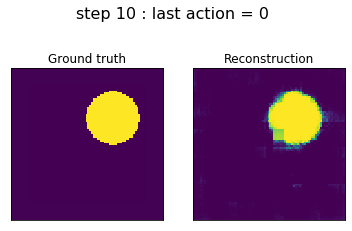

In [420]:
def plot_state(obs, ax):
    ax.imshow(obs)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax

n_steps = 10

fig, (ax1,ax2) = plt.subplots(1, 2)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = obs_env.reset()
        obs_z = lat_env.reset(encoder(obs_x))
    else:
        action = obs_env.action_space.sample().item()
        obs_x = obs_env.step(action)
        obs_z = lat_env.step(action)
        
    obs_x_recon = decoder(obs_z)
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)

**Show 2D projections of learned representations in latent space**

In [421]:
from sklearn.random_projection import GaussianRandomProjection

latent_points = []

for start_position in obs_env.start_positions:
    obs = obs_env.reset(start_position=start_position)
    latent = encoder(obs)
    latent_points.append(latent.detach().tolist())

latent_map = np.array(latent_points)

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


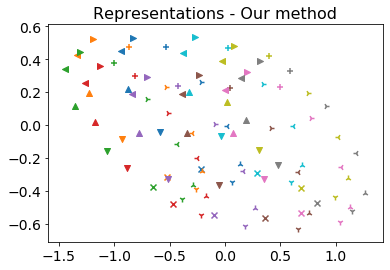

In [422]:
period = obs_env.period

color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',"#2fa36b",'#2f14fb','#ada854','#c353cc','#1c1392','#8eeeb0']
marks=["1","2","3","4","+",">","<","^","v","x","d","p","P","X",'_','|']
pca = GaussianRandomProjection(n_components=2)

latent_2d = pca.fit_transform(latent_map)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)#, projection='3d')
s=[120]*5+[50]*6
for i in range (period**2):
    ax.scatter(x=latent_2d.transpose()[0][i],
                y=latent_2d.transpose()[1][i],
             #   zs=latent_2d.transpose()[2][i],
                c=color[i//period],
                #s=s[i%period],
                marker=marks[i%period])
 #   ax.set_xlim(-.6/1.4,.6/1.4)
  #  ax.set_ylim(-.8/1.4,.8/1.4)
  #  ax.set_zlim(-1./1.6,1./1.6)
    #ax.view_init(elev=45, azim=45)
plt.title('Representations - Our method',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.show()
plt.savefig("latent_flatland.png", bbox_inches='tight')